# $e^{x}$

La función $e^{x}$ se puede calcular con la siguiente serie:

$$
e^{x} =  1 + x + \frac{x^{2}}{2!} + \frac{x^{3}}{3!} + \frac{x^{4}}{4!} + \cdots
$$

La precisión de esta aproximación variará con la cantidad de términos que se calcule.

In [1]:
! rm *.c *.o *.so

Una primera aproximación es la siguiente

In [2]:
def e_x_slow(x, n_terms):
  res = 0
  for n in range(n_terms):
    p = 1
    for i in range(1, n+1):
      p *= i
    tn = (x ** n) / p
    res += tn
  return res

Pero si se encuentra una relación entre el término $t_{n}$ y el término $t_{n-1}$ se puede implementar una versión más eficiente. Caso por caso:

Cuando n = 0:
$$
t_{1} = x ∧ t_{0} = 1 \Rightarrow t_{1} = t_{0} \frac{x}{1}
$$

Cuando n = 1:
$$
t_{2} = \frac{x^{2}}{2!} ∧ t_{1} = x \Rightarrow t_{2} = t_{1} \frac{x}{2}
$$

Cuando n = 2:
$$
t_{3} = \frac{x^{3}}{3!} ∧ t_{2} = \frac{x^{2}}{2!} \Rightarrow t_{3} = t_{2} \frac{x}{3}
$$

En general:
$$
t_{n} = t_{n-1} \frac{x}{n}
$$


In [3]:
def e_x_fast(x, n_terms):
  tn = 1
  res = 0
  for n in range(1,n_terms):
    res += tn
    tn = tn * (x / n)
  return res

Si se hace una prueba al vuelo para ver que como van los resultados se ve lo siguiente

In [4]:
n_terms = 65
x = 20

In [5]:
import math

In [6]:
e_x_slow(x, n_terms), e_x_fast(x, n_terms), math.e ** x

(485165195.4097895, 485165195.40978837, 485165195.40978974)

Ahora se procede a implementar la versión rápida en C

In [7]:
%%file funcs.c

#include <stdint.h>

double c_e_double(double x, uint64_t n_terms){
    double tn = 1.0;
    double res = 0.0;
    for(uint64_t n = 1; n < n_terms; n++){
        res += tn;
        tn = tn * ( x / (double)(n));
    }
    return res;
}

long double c_e_longdouble(long double x, uint64_t n_terms){
    long double tn = 1.0;
    long double res = 0.0;
    for(uint64_t n = 1; n < n_terms; n++){
        res += tn;
        tn = tn * ( x / (long double)(n));
    }
    return res;
}


Writing funcs.c


Comandos para generar el *object file* y la *shared library*

In [8]:
! gcc -c funcs.c -o funcs.o

In [9]:
! gcc -shared funcs.o -o funcs.so 

Función para enlazar las funciones en `C` con `Python` por medio de `ctypes`

In [10]:
import ctypes

In [11]:
def ctypes_funcs():
    # indicar la ruta de la shared library
    libfile = './funcs.so'

    # cargar la shared library
    lib = ctypes.CDLL(libfile)

    # tipo de dato de los argumentos de e_slow
    lib.c_e_double.argtypes = [ctypes.c_double, ctypes.c_uint64]

    # tipo de dato del resultado de e_slow
    lib.c_e_double.restype = ctypes.c_double

    # tipo de dato de los argumentos de e_slow
    lib.c_e_longdouble.argtypes = [ctypes.c_longdouble, ctypes.c_uint64]

    # tipo de dato del resultado de e_slow
    lib.c_e_longdouble.restype = ctypes.c_longdouble
    
    # funciones configuradas
    return lib.c_e_double, lib.c_e_longdouble

Instancias de las funciones

In [12]:
c_e_double, c_e_longdouble = ctypes_funcs()

Pruebas al vuelo de las funciones

In [13]:
c_e_double(x, n_terms), c_e_longdouble(x, n_terms), math.e ** x

(485165195.40978837, 485165195.4097882, 485165195.40978974)

¿Cuántos términos se necesitan para calcular $e^{10}$ con una precisión de `1e-15`?

In [14]:
err = 0
n_terms = 0
x = 10
l = []
while (True):
  res, ref = c_e_double(x, n_terms), math.e ** x
  err = abs(res - ref) / abs(ref)
  print(f'e^{x} con {n_terms} tiene {err} de error')
  if err < 1e-15:
    break
  n_terms += 1

e^10 con 0 tiene 1.0 de error
e^10 con 1 tiene 1.0 de error
e^10 con 2 tiene 0.9999546000702375 de error
e^10 con 3 tiene 0.9995006007726127 de error
e^10 con 4 tiene 0.9972306042844884 de error
e^10 con 5 tiene 0.9896639493240742 de error
e^10 con 6 tiene 0.970747311923039 de error
e^10 con 7 tiene 0.9329140371209681 de error
e^10 con 8 tiene 0.869858579117517 de error
e^10 con 9 tiene 0.7797793533983008 de error
e^10 con 10 tiene 0.6671803212492808 de error
e^10 con 11 tiene 0.5420702855281474 de error
e^10 con 12 tiene 0.41696024980701407 de error
e^10 con 13 tiene 0.3032238536968928 de error
e^10 con 14 tiene 0.2084435236051251 de error
e^10 con 15 tiene 0.1355355773806884 de error
e^10 con 16 tiene 0.08345847293466216 de error
e^10 con 17 tiene 0.048740403303978004 de error
e^10 con 18 tiene 0.027041609784800368 de error
e^10 con 19 tiene 0.014277613597048875 de error
e^10 con 20 tiene 0.007186504603853619 de error
e^10 con 21 tiene 0.0034543419758560467 de error
e^10 con 22 tiene

Se necesitan `45` términos

In [15]:
n_terms

46

Para esta cantidad de términos. ¿Cómo será el tiempo de ejecución de las funciones implementadas?

In [16]:
import time

In [17]:
veces = 50

In [18]:
t_py_slow = []
t_py_fast = []
t_c_double = []
t_c_longdouble = []
for i in range(veces):
    tic = time.perf_counter()
    e_x_slow(x, n_terms)
    toc = time.perf_counter()
    t_py_slow.append(toc - tic)

    tic = time.perf_counter()
    e_x_fast(x, n_terms)
    toc = time.perf_counter()
    t_py_fast.append(toc - tic)

    tic = time.perf_counter()
    c_e_double(x, n_terms)
    toc = time.perf_counter()
    t_c_double.append(toc - tic)

    tic = time.perf_counter()
    c_e_longdouble(x, n_terms)
    toc = time.perf_counter()
    t_c_longdouble.append(toc - tic)

Gráficas de mediciones y mediana

In [19]:
import matplotlib.pyplot as plt

In [20]:
import statistics

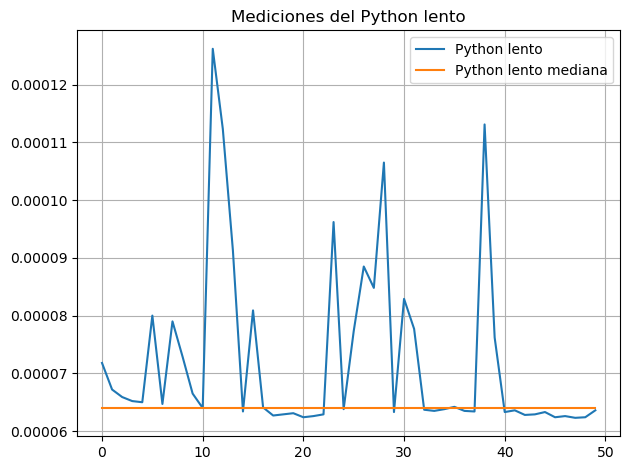

In [21]:
plt.plot(range(veces), t_py_slow, label='Python lento')
plt.plot(range(veces), [statistics.median(t_py_slow)]*len(t_py_slow), label='Python lento mediana')
plt.legend()
plt.grid(True)
plt.title('Mediciones del Python lento')
plt.tight_layout()

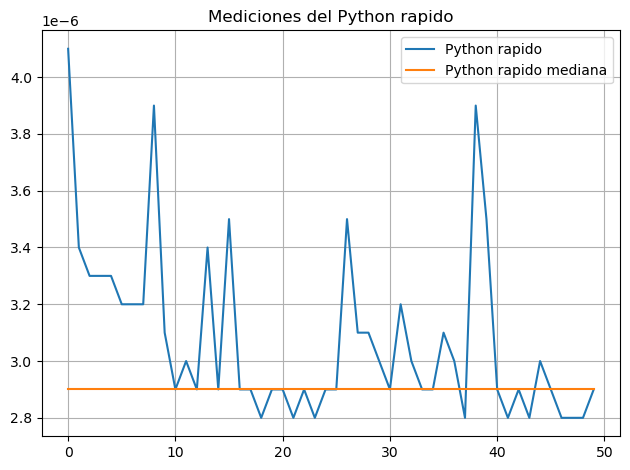

In [22]:
plt.plot(range(veces), t_py_fast, label='Python rapido')
plt.plot(range(veces), [statistics.median(t_py_fast)]*len(t_py_fast), label='Python rapido mediana')
plt.legend()
plt.grid(True)
plt.title('Mediciones del Python rapido')
plt.tight_layout()

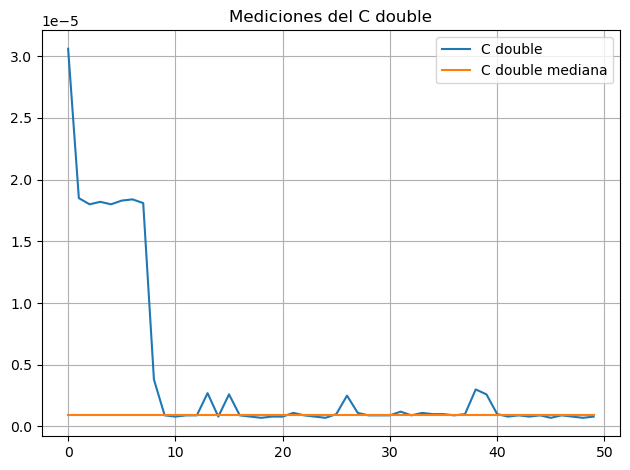

In [23]:
plt.plot(range(veces), t_c_double, label='C double')
plt.plot(range(veces), [statistics.median(t_c_double)]*len(t_c_double), label='C double mediana')
plt.legend()
plt.grid(True)
plt.title('Mediciones del C double')
plt.tight_layout()

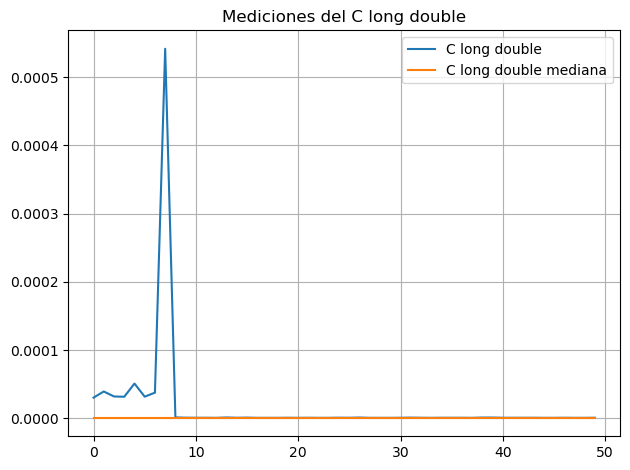

In [24]:
plt.plot(range(veces), t_c_longdouble, label='C long double')
plt.plot(range(veces), [statistics.median(t_c_longdouble)]*len(t_c_longdouble), label='C long double mediana')
plt.legend()
plt.grid(True)
plt.title('Mediciones del C long double')
plt.tight_layout()

Gráfico de barras de las medianas de las mediciones para cada caso

In [25]:
medianas = statistics.median(t_py_slow), statistics.median(t_py_fast), statistics.median(t_c_double), statistics.median(t_c_longdouble)

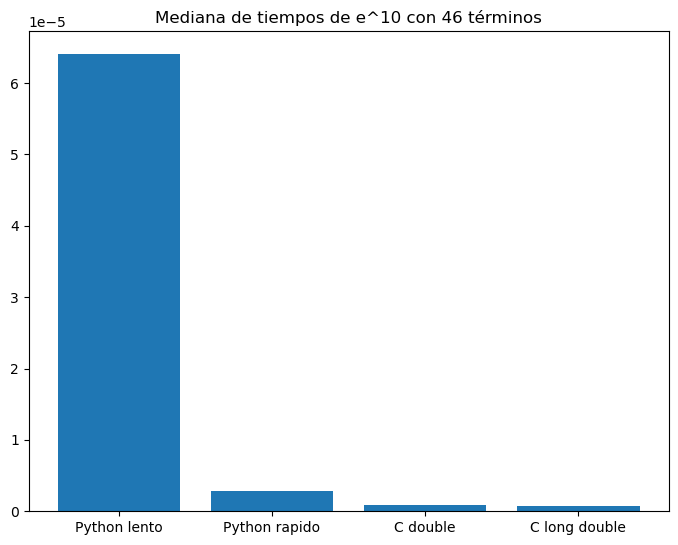

In [26]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
casos = ['Python lento', 'Python rapido', 'C double', 'C long double']
ax.bar(casos, medianas)
plt.title(f'Mediana de tiempos de e^{x} con {n_terms} términos')
plt.show()

Gráfico de barras de los speedups

In [27]:
speedups = statistics.median(t_py_slow) / statistics.median(t_py_fast), statistics.median(t_py_slow) / statistics.median(t_c_double), statistics.median(t_py_slow) / statistics.median(t_c_longdouble)

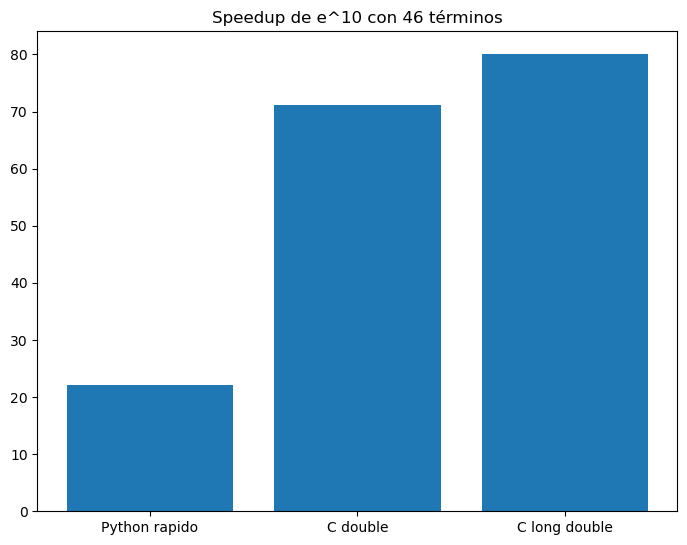

In [28]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
casos = ['Python rapido', 'C double', 'C long double']
ax.bar(casos, speedups)
plt.title(f'Speedup de e^{x} con {n_terms} términos')
plt.show()

El rendimiento de la versión con `double` no es tan diferente que la versión con `long double`. ¿Cuál versión elegiría usted? ¿Por qué?